<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/apura%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 importações de bibliotecas e recursos

In [1]:
import pandas as pd
import numpy as np
import requests
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import cmath

# 2 funções para fazer as devidas requisições na api

In [3]:
def getDeputadoEstadualUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0007-e000546-r.json'

def getPresidentUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/544/dados-simplificados/{uf}/{uf}-c0001-e000544-r.json'

def getGovernadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0003-e000546-r.json'

def getDeputadoFederalUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0006-e000546-r.json'

def getSenadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0005-e000546-r.json'

gets= [getPresidentUrl, getSenadorUrl, getDeputadoFederalUrl, getDeputadoEstadualUrl, getGovernadorUrl]
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

LULA_TAG          = 'LULA' 
BOLSONARO_TAG     = 'JAIR BOLSONARO' 
CIRO_TAG          = 'CIRO GOMES' 
TEBET_TAG         = 'SIMONE TEBET' 
SORAYA_TAG        = 'SORAYA THRONICKE' 
DAVILA_TAG        =  "FELIPE D'AVILA"
PADRE_TAG         = 'PADRE KELMON' 
SOFIA_MANZANO_TAG = 'SOFIA MANZANO' 
LEO_PERICLES_TAG  ='LÉO PÉRICLES'
VERA_TAG          = 'VERA' 
EYMAEL_TAG        = 'CONSTITUINTE EYMAEL'
candidatesTags    = [LULA_TAG, BOLSONARO_TAG, CIRO_TAG, TEBET_TAG, SORAYA_TAG, DAVILA_TAG, PADRE_TAG, SOFIA_MANZANO_TAG, LEO_PERICLES_TAG, VERA_TAG, EYMAEL_TAG]
cadidatesColors   =['red', 'green', 'blue','red', 'green', 'blue','red', 'green', 'blue','green','yellow']

# Criação do electionsData
### ele é um objeto mais organizado contendo todas as informações separadas por estado

In [4]:
def takeData(url):
  re=requests.get(url).json()
  candidatos = re['cand']

  df=pd.DataFrame(candidatos)
  df=df[['nm','n','dvt','vap','pvap']]
  df.rename(columns={'nm':'Nome do Candidato',
                  'n':'Numero do Candidato',
                  'dvt':'Validade',
                  'vap':'Votos',
                  'pvap':'(%) Votos'}, inplace=True)
  
  df['(%) Votos']=df['(%) Votos'].str.replace(',','.')
  df['(%) Votos']=df['(%) Votos'].astype(float)
  df['Votos']=df['Votos'].astype(int)
  df['Nome do Candidato']=df['Nome do Candidato'].str.replace('D&apos;',"D'")
  df=df.sort_values(by='Votos', ascending=False)
  return(df)

In [5]:
def getAllDataByUf(uf):
  info = {}
  for index, category in enumerate(categoryKeys):
    try:
      info[category] = takeData(gets[index](uf))
    except:
      if uf == 'df':
        info[category] = 'df não tem prefeito'
      else:
        info[category] = 'this is brasil'
  return info

In [6]:
electionsData = {}
electionsData['br'] = getAllDataByUf('br')
for i, uf in  enumerate(brasil_ufs):
  electionsData[uf] = getAllDataByUf(uf)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# funções para analizar diferenças entre condidatos

In [7]:
def getDiffBetweenTwoCandidates(uf, category='Presidente', candidates=['JAIR BOLSONARO' , 'LULA'], attr = '(%) Votos'):
  keysArray = list(electionsData[uf][category].keys()[0:5].array)
  positionOtAttr = keysArray.index(attr)
  usedData = electionsData[uf][category].values
  [candidateOne,candidateTwo] = candidates
  candidateOneScore = list(filter(lambda x: x[0]== candidateOne,usedData))[0][positionOtAttr]
  candidateTwoScore = list(filter(lambda x: x[0]== candidateTwo,usedData))[0][positionOtAttr]
  result = float(format(abs(candidateOneScore - candidateTwoScore),'.2f'))
  winer = candidateOne if candidateOneScore > candidateTwoScore else candidateTwo
  return result , winer

In [15]:
getVotesDiffBetweenTwoCandidates = lambda uf,candidates:  getDiffBetweenTwoCandidates(uf=uf , candidates=candidates, attr='Votos')

In [ ]:
getPPDiffBetweenTwoCandidates = lambda uf: getDiffBetweenTwoCandidates(uf=uf)

In [14]:
getPPDiffBetweenJairAndLula = lambda uf: getDiffBetweenTwoCandidates(uf=uf)

# Os Graficos Começam daqui pra baixo

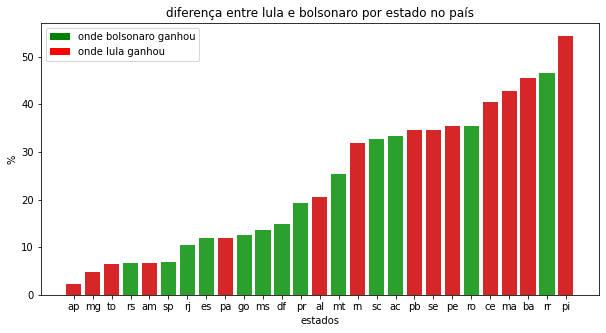

In [17]:

ordened_ufs = sorted(brasil_ufs,key=lambda uf: getPPDiffBetweenJairAndLula(uf)[0])
fig, ax = plt.subplots()
counts = (list(map(lambda uf : getPPDiffBetweenJairAndLula(uf)[0],ordened_ufs)))
bar_colors = list(map(lambda uf : 'tab:green' if getPPDiffBetweenJairAndLula(uf)[1] == BOLSONARO_TAG else 'tab:red',ordened_ufs))
fig.set_size_inches(10,5)
ax.bar(ordened_ufs, counts, color = bar_colors)
ax.bar([0], [0], color = 'green', label='onde bolsonaro ganhou') #metodo para conseguir colocar a legenda
ax.bar([0 ],[0 ], color = 'red', label='onde lula ganhou')
ax.set_ylabel('%')
ax.set_xlabel('estados')
ax.set_title('diferença entre lula e bolsonaro por estado no país')
ax.legend()

plt.show()

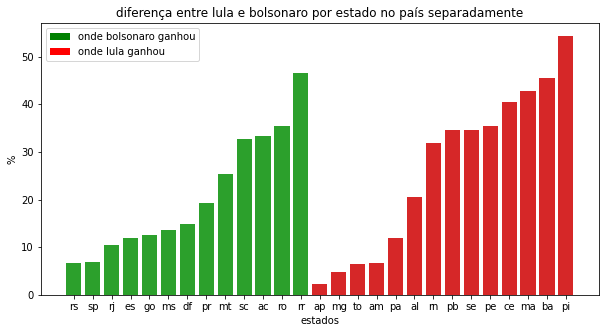

In [16]:
def separeLulaBolsoBars(uf):
  acrecimo = 0 if getPPDiffBetweenJairAndLula(uf)[1] ==  BOLSONARO_TAG else 100
  return getPPDiffBetweenJairAndLula(uf)[0] + acrecimo

ordened_ufs = sorted(brasil_ufs,key=separeLulaBolsoBars)

counts = (list(map(lambda uf : getPPDiffBetweenJairAndLula(uf)[0],ordened_ufs)))
bar_colors = list(map(lambda uf : 'tab:green' if getPPDiffBetweenJairAndLula(uf)[1] == BOLSONARO_TAG else 'tab:red',ordened_ufs))
fig, ax = plt.subplots()
ax.bar(ordened_ufs, counts, color = bar_colors)
ax.bar([0], [0], color = 'green', label='onde bolsonaro ganhou') #metodo para conseguir colocar a legenda
ax.bar([0 ],[0 ], color = 'red', label='onde lula ganhou')
# bar_colors = list(map(lambda uf : getPPDiffBetweenJairNine(uf)[1],ordened_ufs))
fig.set_size_inches(10,5)
ax.set_ylabel('%')
ax.set_xlabel('estados')
ax.set_title('diferença entre lula e bolsonaro por estado no país separadamente')
ax.legend()

plt.show()

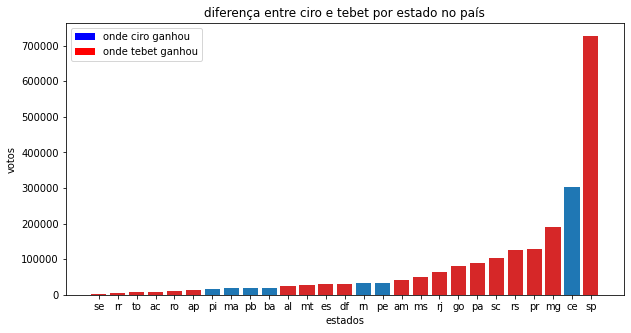

In [19]:
diffCiroTebet = lambda uf : getVotesDiffBetweenTwoCandidates(uf=uf,candidates=[CIRO_TAG,TEBET_TAG])
ordened_ufs = sorted(brasil_ufs, key = lambda uf : diffCiroTebet(uf)[0])
counts = list(map(lambda uf: diffCiroTebet(uf)[0],ordened_ufs))
bar_colors = list(map(lambda uf: 'tab:blue' if diffCiroTebet(uf)[1] == CIRO_TAG else 'tab:red',ordened_ufs))

fig, ax = plt.subplots()
ax.bar(ordened_ufs, counts, color = bar_colors)
ax.bar([0], [0], color = 'blue', label='onde ciro ganhou') #metodo para conseguir colocar a legenda
ax.bar([0 ],[0 ], color = 'red', label='onde tebet ganhou')
# bar_colors = list(map(lambda uf : getPPDiffBetweenJairNine(uf)[1],ordened_ufs))
fig.set_size_inches(10,5)
ax.set_ylabel('votos')
ax.set_xlabel('estados')
ax.set_title('diferença entre ciro e tebet por estado no país')
ax.legend()

plt.show()